In [1]:
import torch
from torch_geometric.nn import HeteroConv, GENConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim, out_dim, n_heads, dropout, edge_attr_dim):
        super().__init__()
        self.conv1 = HeteroConv(
            {
                edge_type: GENConv(
                    in_channels=(-1, -1),
                    out_channels=hidden_dim,
                    edge_dim=edge_attr_dim,
                    learn_t=True,
                )
                for edge_type in metadata[1]
            },
            aggr="sum",
        )
        self.conv2 = HeteroConv(
            {
                edge_type: GENConv(
                    in_channels=(-1, -1),
                    out_channels=out_dim,
                    edge_dim=edge_attr_dim,
                    learn_t=True,
                )
                for edge_type in metadata[1]
            },
            aggr="sum",
        )

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        x_dict = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        x_dict = {k: v.relu() for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict, edge_attr_dict)
        return x_dict

In [4]:
class MultiTypeEdgePredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_attr_dim, num_edge_types):
        super().__init__()
        self.edge_attr_dim = edge_attr_dim
        self.num_edge_types = num_edge_types

        input_dim = in_channels + edge_attr_dim

        # Shared layers: feature extraction
        self.shared_layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
        )

        # Binary classifier: does an edge exist?
        self.edge_existence_head = torch.nn.Linear(hidden_channels // 2, 1)

        # Multi-class classifier: what type of edge?
        self.edge_type_head = torch.nn.Linear(hidden_channels // 2, num_edge_types)

    def forward(self, src_emb, dst_emb, edge_attr=None):
        x = torch.cat([src_emb, dst_emb], dim=-1)

        if edge_attr is not None and self.edge_attr_dim is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.unsqueeze(-1)
            x = torch.cat([x, edge_attr], dim=-1)

        shared_features = self.shared_layers(x)
        edge_existence_logits = self.edge_existence_head(shared_features).squeeze(-1)
        edge_type_logits = self.edge_type_head(shared_features)
        return edge_existence_logits, edge_type_logits

In [5]:
graph_path_name = "graph_biobert_128_dim_hetero"
graph_data = torch.load(f"../graphs/{graph_path_name}.pt", weights_only=False)

edge_attr_dim = list(graph_data.edge_attr_dict.values())[0].shape[1]
metadata = graph_data.metadata()

In [6]:
def get_edge_attributes(data, edge_type, edge_index, device):
    """
    Get edge attributes for given edge indices. For edges that don't exist in the original graph,
    use mean edge attributes or learnable embeddings.
    """
    if edge_index.shape[1] == 0:
        edge_attr_dim = data[edge_type].edge_attr.shape[1]
        return torch.empty(0, edge_attr_dim, device=device)

    original_edge_index = data[edge_type].edge_index
    original_edge_attr = data[edge_type].edge_attr

    edge_to_attr = {}
    for i in range(original_edge_index.shape[1]):
        src, dst = original_edge_index[0, i].item(), original_edge_index[1, i].item()
        edge_to_attr[(src, dst)] = original_edge_attr[i]

    edge_attrs = []
    mean_attr = original_edge_attr.mean(dim=0)

    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i].item(), edge_index[1, i].item()
        if (src, dst) in edge_to_attr:
            edge_attrs.append(edge_to_attr[(src, dst)])
        else:
            edge_attrs.append(mean_attr)

    return torch.stack(edge_attrs).to(device)


def prepare_multi_type_training_data(
    data, edge_types, device, max_samples_per_type=1000
):
    """
    Prepare training data from all edge types for multi-task learning.
    """
    all_pos_edges = []
    all_neg_edges = []
    all_pos_edge_attrs = []
    all_neg_edge_attrs = []
    all_pos_edge_type_labels = []
    all_neg_edge_type_labels = []
    all_pos_node_pairs = []
    all_neg_node_pairs = []

    edge_type_to_idx = {edge_type: idx for idx, edge_type in enumerate(edge_types)}

    for edge_type_idx, edge_type in enumerate(edge_types):
        if not hasattr(data[edge_type], "edge_label_index"):
            continue

        edge_label_index = data[edge_type].edge_label_index
        edge_labels = data[edge_type].edge_label

        pos_mask = edge_labels == 1
        neg_mask = edge_labels == 0

        pos_edge_index = edge_label_index[:, pos_mask]
        neg_edge_index = edge_label_index[:, neg_mask]

        if pos_edge_index.shape[1] == 0 or neg_edge_index.shape[1] == 0:
            continue

        if pos_edge_index.shape[1] > max_samples_per_type:
            indices = torch.randperm(pos_edge_index.shape[1])[:max_samples_per_type]
            pos_edge_index = pos_edge_index[:, indices]

        if neg_edge_index.shape[1] > max_samples_per_type:
            indices = torch.randperm(neg_edge_index.shape[1])[:max_samples_per_type]
            neg_edge_index = neg_edge_index[:, indices]

        pos_edge_attrs = get_edge_attributes(data, edge_type, pos_edge_index, device)
        neg_edge_attrs = get_edge_attributes(data, edge_type, neg_edge_index, device)

        all_pos_node_pairs.append(pos_edge_index)
        all_neg_node_pairs.append(neg_edge_index)
        all_pos_edge_attrs.append(pos_edge_attrs)
        all_neg_edge_attrs.append(neg_edge_attrs)

        pos_edge_type_labels = torch.full(
            (pos_edge_index.shape[1],), edge_type_idx, dtype=torch.long
        )
        neg_edge_type_labels = torch.full(
            (neg_edge_index.shape[1],), edge_type_idx, dtype=torch.long
        )

        all_pos_edge_type_labels.append(pos_edge_type_labels)
        all_neg_edge_type_labels.append(neg_edge_type_labels)

        all_pos_edges.append((edge_type, pos_edge_index))
        all_neg_edges.append((edge_type, neg_edge_index))

    return {
        "pos_edges": all_pos_edges,
        "neg_edges": all_neg_edges,
        "pos_node_pairs": all_pos_node_pairs,
        "neg_node_pairs": all_neg_node_pairs,
        "pos_edge_attrs": all_pos_edge_attrs,
        "neg_edge_attrs": all_neg_edge_attrs,
        "pos_edge_type_labels": all_pos_edge_type_labels,
        "neg_edge_type_labels": all_neg_edge_type_labels,
        "edge_type_to_idx": edge_type_to_idx,
    }

In [7]:
splitter = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=True,
    edge_types=graph_data.edge_types,
    rev_edge_types=None,
)

train_data, val_data, test_data = splitter(graph_data)

In [8]:
hidden_dim = 256
out_dim = 128
n_heads = 2
dropout = 0.2
patience = 5

edge_types = graph_data.edge_types
num_edge_types = len(edge_types)
edge_type_to_idx = {edge_type: idx for idx, edge_type in enumerate(edge_types)}

model = HeteroGNN(
    metadata=metadata,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    n_heads=n_heads,
    dropout=dropout,
    edge_attr_dim=edge_attr_dim,
).to(device)

predictor = MultiTypeEdgePredictor(
    in_channels=out_dim * 2,
    hidden_channels=64,
    edge_attr_dim=edge_attr_dim,
    num_edge_types=num_edge_types,
).to(device)

In [9]:
def evaluate_multi_type_model(
    model, predictor, data, edge_types, edge_type_to_idx, device
):
    model.eval()

    all_existence_preds = []
    all_existence_true = []
    all_type_preds = []
    all_type_true = []

    edge_type_results = {}

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        for edge_type in edge_types:
            if not hasattr(data[edge_type], "edge_label_index"):
                continue

            edge_label_index = data[edge_type].edge_label_index.to(device)
            edge_labels = data[edge_type].edge_label.to(device)

            if len(edge_labels) == 0:
                edge_type_results[edge_type] = {
                    "existence_auc": 0.0,
                    "existence_acc": 0.0,
                    "type_acc": 0.0,
                    "num_samples": 0,
                    "num_positive": 0,
                }
                continue

            src_embeddings = out[edge_type[0]][edge_label_index[0]]
            dst_embeddings = out[edge_type[2]][edge_label_index[1]]

            edge_attrs = get_edge_attributes(data, edge_type, edge_label_index, device)

            existence_logits, type_logits = predictor(
                src_embeddings, dst_embeddings, edge_attrs
            )
            existence_probs = torch.sigmoid(existence_logits).cpu().numpy()
            type_preds = torch.argmax(type_logits, dim=1).cpu().numpy()

            existence_true = edge_labels.cpu().numpy()
            type_true = torch.full(
                (len(existence_true),), edge_type_to_idx[edge_type]
            ).numpy()

            all_existence_preds.extend(existence_probs)
            all_existence_true.extend(existence_true)
            all_type_preds.extend(type_preds)
            all_type_true.extend(type_true)

            unique_labels = np.unique(existence_true)
            if len(unique_labels) > 1:
                existence_auc = roc_auc_score(existence_true, existence_probs)
            else:
                existence_auc = 0.0

            existence_acc = accuracy_score(existence_true, existence_probs > 0.5)

            pos_mask = existence_true == 1
            if pos_mask.sum() > 0:
                type_acc = accuracy_score(type_true[pos_mask], type_preds[pos_mask])
            else:
                type_acc = 0.0

            edge_type_results[edge_type] = {
                "existence_auc": existence_auc,
                "existence_acc": existence_acc,
                "type_acc": type_acc,
                "num_samples": len(existence_true),
                "num_positive": pos_mask.sum(),
            }

    if len(all_existence_true) > 0:
        unique_labels = np.unique(all_existence_true)
        if len(unique_labels) > 1:
            overall_existence_auc = roc_auc_score(
                all_existence_true, all_existence_preds
            )
        else:
            overall_existence_auc = 0.0
        overall_existence_acc = accuracy_score(
            all_existence_true, np.array(all_existence_preds) > 0.5
        )
        overall_type_acc = accuracy_score(all_type_true, all_type_preds)
    else:
        overall_existence_auc = 0.0
        overall_existence_acc = 0.0
        overall_type_acc = 0.0

    return {
        "overall_existence_auc": overall_existence_auc,
        "overall_existence_acc": overall_existence_acc,
        "overall_type_acc": overall_type_acc,
        "edge_type_results": edge_type_results,
    }

In [10]:
training_data = prepare_multi_type_training_data(
    train_data, edge_types, device, max_samples_per_type=2000
)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.005
)

best_val_acc = 0.0
patience_counter = 0
patience = 15
train_losses = []
val_accuracies = []

for epoch in range(1, 101):
    model.train()
    predictor.train()
    optimizer.zero_grad()

    x_dict = {k: v.to(device) for k, v in train_data.x_dict.items()}
    edge_index_dict = {k: v.to(device) for k, v in train_data.edge_index_dict.items()}
    edge_attr_dict = {k: v.to(device) for k, v in train_data.edge_attr_dict.items()}
    out = model(x_dict, edge_index_dict, edge_attr_dict)

    epoch_existence_loss = 0
    epoch_type_loss = 0

    for i, edge_type in enumerate(edge_types):
        if i >= len(training_data["pos_edges"]):
            continue

        _, pos_edge_index = training_data["pos_edges"][i]
        pos_edge_attrs = training_data["pos_edge_attrs"][i]
        pos_edge_type_labels = training_data["pos_edge_type_labels"][i].to(device)

        _, neg_edge_index = training_data["neg_edges"][i]
        neg_edge_attrs = training_data["neg_edge_attrs"][i]

        if len(pos_edge_index[0]) == 0 or len(neg_edge_index[0]) == 0:
            continue

        src_emb_pos = out[edge_type[0]][pos_edge_index[0]]
        dst_emb_pos = out[edge_type[2]][pos_edge_index[1]]
        src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
        dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]

        pos_existence_logits, pos_type_logits = predictor(
            src_emb_pos, dst_emb_pos, pos_edge_attrs
        )
        neg_existence_logits, neg_type_logits = predictor(
            src_emb_neg, dst_emb_neg, neg_edge_attrs
        )

        all_existence_logits = torch.cat([pos_existence_logits, neg_existence_logits])
        existence_labels = torch.cat(
            [
                torch.ones(len(pos_existence_logits), device=device),
                torch.zeros(len(neg_existence_logits), device=device),
            ]
        )

        existence_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            all_existence_logits, existence_labels
        )
        type_loss = torch.nn.functional.cross_entropy(
            pos_type_logits, pos_edge_type_labels
        )
        epoch_existence_loss += existence_loss
        epoch_type_loss += type_loss

    num_valid_types = min(len(training_data["pos_edges"]), len(edge_types))
    if num_valid_types > 0:
        avg_existence_loss = epoch_existence_loss / num_valid_types
        avg_type_loss = epoch_type_loss / num_valid_types
        total_loss = avg_existence_loss + 0.5 * avg_type_loss

        total_loss.backward()
        optimizer.step()
        train_losses.append(total_loss.item())

        val_results = evaluate_multi_type_model(
            model, predictor, val_data, edge_types, edge_type_to_idx, device
        )
        val_acc = val_results["overall_existence_acc"]
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
            print(f"New best validation accuracy: {val_acc:.3f} at epoch {epoch}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(
                f"Early stopping at epoch {epoch}: Train Loss = {total_loss.item():.4f} | Val Accuracy = {val_acc:.3f} | Best Val Accuracy = {best_val_acc:.3f}"
            )
            break

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:3d}: Train Loss = {total_loss.item():.4f} | Val Accuracy = {val_acc:.3f} | Best Val Accuracy = {best_val_acc:.3f}"
            )

        model.train()
        predictor.train()

New best validation accuracy: 0.500 at epoch 1
Epoch   1: Train Loss = 2.1437 | Val Accuracy = 0.500 | Best Val Accuracy = 0.500
New best validation accuracy: 0.505 at epoch 3
New best validation accuracy: 0.650 at epoch 4
New best validation accuracy: 0.720 at epoch 5
Epoch  10: Train Loss = 0.4766 | Val Accuracy = 0.692 | Best Val Accuracy = 0.720
Early stopping at epoch 20: Train Loss = 0.2576 | Val Accuracy = 0.696 | Best Val Accuracy = 0.720


In [11]:
test_results = evaluate_multi_type_model(
    model, predictor, test_data, edge_types, edge_type_to_idx, device
)

print(f"Overall Edge Existence AUC: {test_results['overall_existence_auc']:.3f}")
print(f"Overall Edge Existence Accuracy: {test_results['overall_existence_acc']:.3f}")
print(f"Overall Edge Type Accuracy: {test_results['overall_type_acc']:.3f}")

Overall Edge Existence AUC: 0.755
Overall Edge Existence Accuracy: 0.687
Overall Edge Type Accuracy: 0.970


In [12]:
graph_data

HeteroData(
  PCG={ x=[1717, 128] },
  lncRNA={ x=[1333, 128] },
  miRNA={ x=[512, 128] },
  TF={ x=[336, 128] },
  snoRNA={ x=[3, 128] },
  circRNA={ x=[7, 128] },
  (lncRNA, regulates, miRNA)={
    edge_index=[2, 1088],
    edge_attr=[1088, 13],
  },
  (lncRNA, regulates, PCG)={
    edge_index=[2, 5029],
    edge_attr=[5029, 13],
  },
  (lncRNA, regulates, TF)={
    edge_index=[2, 1570],
    edge_attr=[1570, 13],
  },
  (PCG, regulates, miRNA)={
    edge_index=[2, 11],
    edge_attr=[11, 13],
  },
  (TF, regulates, lncRNA)={
    edge_index=[2, 303],
    edge_attr=[303, 13],
  },
  (lncRNA, regulates, lncRNA)={
    edge_index=[2, 34],
    edge_attr=[34, 13],
  },
  (miRNA, regulates, lncRNA)={
    edge_index=[2, 82],
    edge_attr=[82, 13],
  },
  (PCG, regulates, PCG)={
    edge_index=[2, 36],
    edge_attr=[36, 13],
  },
  (circRNA, regulates, miRNA)={
    edge_index=[2, 3],
    edge_attr=[3, 13],
  },
  (circRNA, regulates, PCG)={
    edge_index=[2, 9],
    edge_attr=[9, 13],
  },


In [13]:
def validate_predictions_against_ground_truth(
    model,
    predictor,
    data,
    edge_types,
    edge_type_to_idx,
    device,
    num_samples,
    data_split_name,
):
    model.eval()
    predictor.eval()

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

    correct_existence_predictions = 0
    correct_type_predictions = 0
    total_predictions = 0
    positive_correct = 0
    negative_correct = 0
    total_positive = 0
    total_negative = 0

    for edge_type in edge_types:
        if not hasattr(data[edge_type], "edge_label_index") or not hasattr(
            data[edge_type], "edge_label"
        ):
            continue

        edge_label_index = data[edge_type].edge_label_index
        edge_labels = data[edge_type].edge_label

        if edge_label_index.shape[1] == 0:
            continue

        pos_mask = edge_labels == 1
        neg_mask = edge_labels == 0
        pos_edge_index = edge_label_index[:, pos_mask]
        neg_edge_index = edge_label_index[:, neg_mask]

        max_samples_per_type = num_samples // len(edge_types) // 2

        # Sample positive edges
        if pos_edge_index.shape[1] > 0:
            num_pos_to_sample = min(max_samples_per_type, pos_edge_index.shape[1])
            if num_pos_to_sample > 0:
                sampled_pos_indices = torch.randperm(pos_edge_index.shape[1])[
                    :num_pos_to_sample
                ]
                sampled_pos_edges = pos_edge_index[:, sampled_pos_indices]

                for i in range(sampled_pos_edges.shape[1]):
                    src_idx = sampled_pos_edges[0, i].item()
                    dst_idx = sampled_pos_edges[1, i].item()

                    src_emb = out[edge_type[0]][src_idx].unsqueeze(0)
                    dst_emb = out[edge_type[2]][dst_idx].unsqueeze(0)
                    edge_attrs = get_edge_attributes(
                        data, edge_type, sampled_pos_edges[:, i : i + 1], device
                    )

                    with torch.no_grad():
                        existence_logits, type_logits = predictor(
                            src_emb, dst_emb, edge_attrs
                        )
                        existence_prob = torch.sigmoid(existence_logits).item()
                        predicted_type_idx = torch.argmax(type_logits, dim=1).item()
                        predicted_type = edge_types[predicted_type_idx]

                    existence_correct = existence_prob > 0.5
                    type_correct = predicted_type == edge_type

                    if existence_correct:
                        correct_existence_predictions += 1
                        positive_correct += 1
                    if type_correct:
                        correct_type_predictions += 1

                    total_predictions += 1
                    total_positive += 1

        # Sample negative edges
        if neg_edge_index.shape[1] > 0:
            num_neg_to_sample = min(max_samples_per_type, neg_edge_index.shape[1])
            if num_neg_to_sample > 0:
                sampled_neg_indices = torch.randperm(neg_edge_index.shape[1])[
                    :num_neg_to_sample
                ]
                sampled_neg_edges = neg_edge_index[:, sampled_neg_indices]

                for i in range(sampled_neg_edges.shape[1]):
                    src_idx = sampled_neg_edges[0, i].item()
                    dst_idx = sampled_neg_edges[1, i].item()

                    src_emb = out[edge_type[0]][src_idx].unsqueeze(0)
                    dst_emb = out[edge_type[2]][dst_idx].unsqueeze(0)
                    edge_attrs = get_edge_attributes(
                        data, edge_type, sampled_neg_edges[:, i : i + 1], device
                    )

                    with torch.no_grad():
                        existence_logits, _ = predictor(src_emb, dst_emb, edge_attrs)
                        existence_prob = torch.sigmoid(existence_logits).item()

                    existence_correct = existence_prob <= 0.5

                    if existence_correct:
                        correct_existence_predictions += 1
                        negative_correct += 1

                    total_predictions += 1
                    total_negative += 1

    existence_accuracy = (
        correct_existence_predictions / total_predictions
        if total_predictions > 0
        else 0
    )
    type_accuracy = (
        correct_type_predictions / total_positive if total_positive > 0 else 0
    )
    positive_accuracy = positive_correct / total_positive if total_positive > 0 else 0
    negative_accuracy = negative_correct / total_negative if total_negative > 0 else 0

    print(f"Final evaluation on {data_split_name} set:")
    print(f"Overall edge existence accuracy: {existence_accuracy:.3f}")
    print(f"Positive edge accuracy: {positive_accuracy:.3f}")
    print(f"Negative edge accuracy: {negative_accuracy:.3f}")
    print(f"Edge type accuracy: {type_accuracy:.3f}")


test_results = validate_predictions_against_ground_truth(
    model, predictor, test_data, edge_types, edge_type_to_idx, device, 200, "test"
)

Final evaluation on test set:
Overall edge existence accuracy: 0.703
Positive edge accuracy: 0.595
Negative edge accuracy: 0.811
Edge type accuracy: 0.973


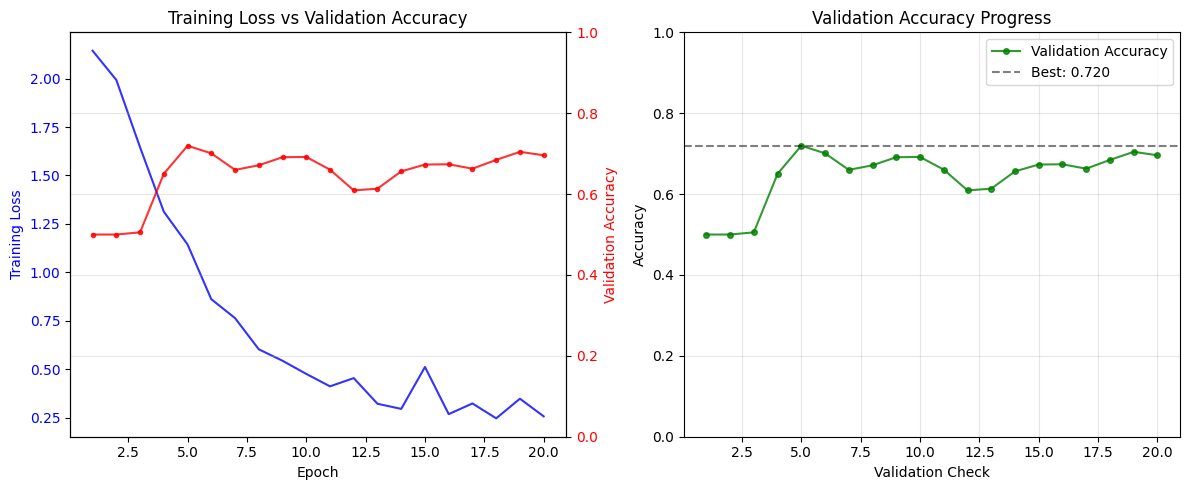

Training Summary:
Total epochs trained: 20
Final training loss: 0.2576
Final validation accuracy: 0.696
Best validation accuracy: 0.720


In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
val_epochs = range(1, len(val_accuracies) + 1)

ax1 = plt.gca()
line1 = ax1.plot(epochs_range, train_losses, "b-", label="Training Loss", alpha=0.8)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
line2 = ax2.plot(
    val_epochs,
    val_accuracies,
    "r-",
    label="Validation Accuracy",
    alpha=0.8,
    marker="o",
    markersize=3,
)
ax2.set_ylabel("Validation Accuracy", color="r")
ax2.tick_params(axis="y", labelcolor="r")
ax2.set_ylim(0, 1)

plt.title("Training Loss vs Validation Accuracy")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(
    val_epochs,
    val_accuracies,
    "g-",
    label="Validation Accuracy",
    alpha=0.8,
    marker="o",
    markersize=4,
)
plt.axhline(
    y=max(val_accuracies),
    color="k",
    linestyle="--",
    alpha=0.5,
    label=f"Best: {max(val_accuracies):.3f}",
)
plt.xlabel("Validation Check")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("Training Summary:")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Final training loss: {train_losses[-1]:.4f}")
if val_accuracies:
    print(f"Final validation accuracy: {val_accuracies[-1]:.3f}")
    print(f"Best validation accuracy: {max(val_accuracies):.3f}")

In [15]:
def generate_and_save_node_embeddings(model, graph_data, device, save_path):
    model.eval()

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in graph_data.x_dict.items()}
        edge_index_dict = {
            k: v.to(device) for k, v in graph_data.edge_index_dict.items()
        }
        edge_attr_dict = {k: v.to(device) for k, v in graph_data.edge_attr_dict.items()}
        node_embeddings = model(x_dict, edge_index_dict, edge_attr_dict)
        node_embeddings_cpu = {
            node_type: embeddings.cpu().numpy()
            for node_type, embeddings in node_embeddings.items()
        }

    print("Node embeddings created:")
    for node_type, embeddings in node_embeddings_cpu.items():
        print(
            f"  {node_type}: {embeddings.shape[0]} nodes x {embeddings.shape[1]} dimensions"
        )

    import pickle

    with open(save_path, "wb") as f:
        pickle.dump(node_embeddings_cpu, f)

    print(f"Node embeddings saved to: {save_path}")

    return node_embeddings_cpu


embeddings_save_path = "../node_embeddings/node_embeddings_128d.pkl"
node_embeddings = generate_and_save_node_embeddings(
    model=model,
    graph_data=graph_data,
    device=device,
    save_path=embeddings_save_path,
)

Node embeddings created:
  miRNA: 512 nodes x 128 dimensions
  PCG: 1717 nodes x 128 dimensions
  TF: 336 nodes x 128 dimensions
  lncRNA: 1333 nodes x 128 dimensions
  snoRNA: 3 nodes x 128 dimensions
  circRNA: 7 nodes x 128 dimensions
Node embeddings saved to: ../node_embeddings/node_embeddings_128d.pkl


Plotting edge score distributions for training data:
Positive edges - Mean: 0.727, Std: 0.280, Count: 3421
Negative edges - Mean: 0.311, Std: 0.247, Count: 3421
Score ranges - Positive: [0.003436, 1.000000], Negative: [0.000002, 1.000000]


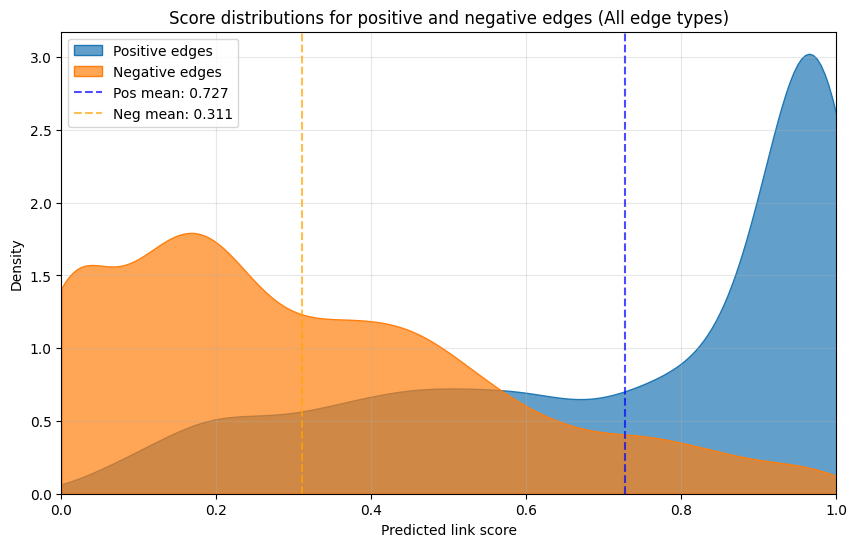


Plotting edge score distributions for test data:
Positive edges - Mean: 0.658, Std: 0.314, Count: 829
Negative edges - Mean: 0.341, Std: 0.229, Count: 829
Score ranges - Positive: [0.000014, 0.999733], Negative: [0.000001, 0.998840]


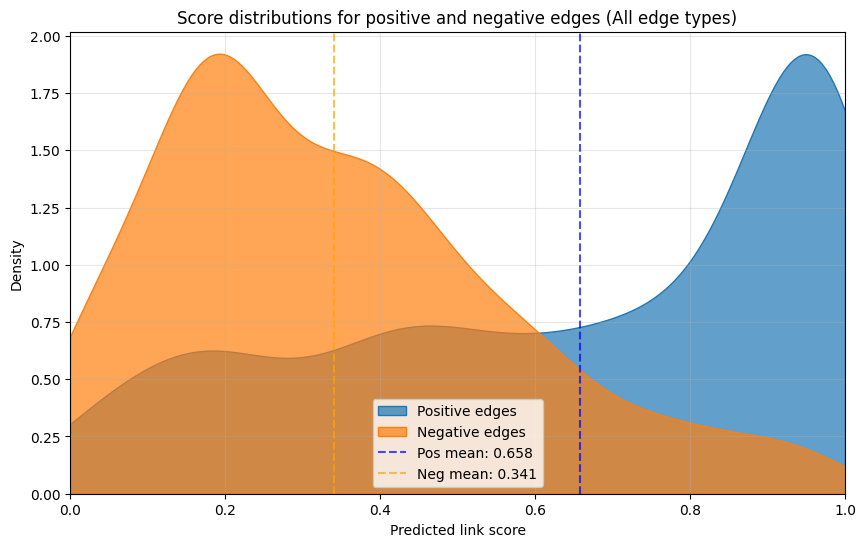


SCORE DISTRIBUTIONS BY EDGE TYPE (TEST DATA)


/tmp/ipykernel_11995/2703596663.py:242: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_11995/2703596663.py:252: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_11995/2703596663.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


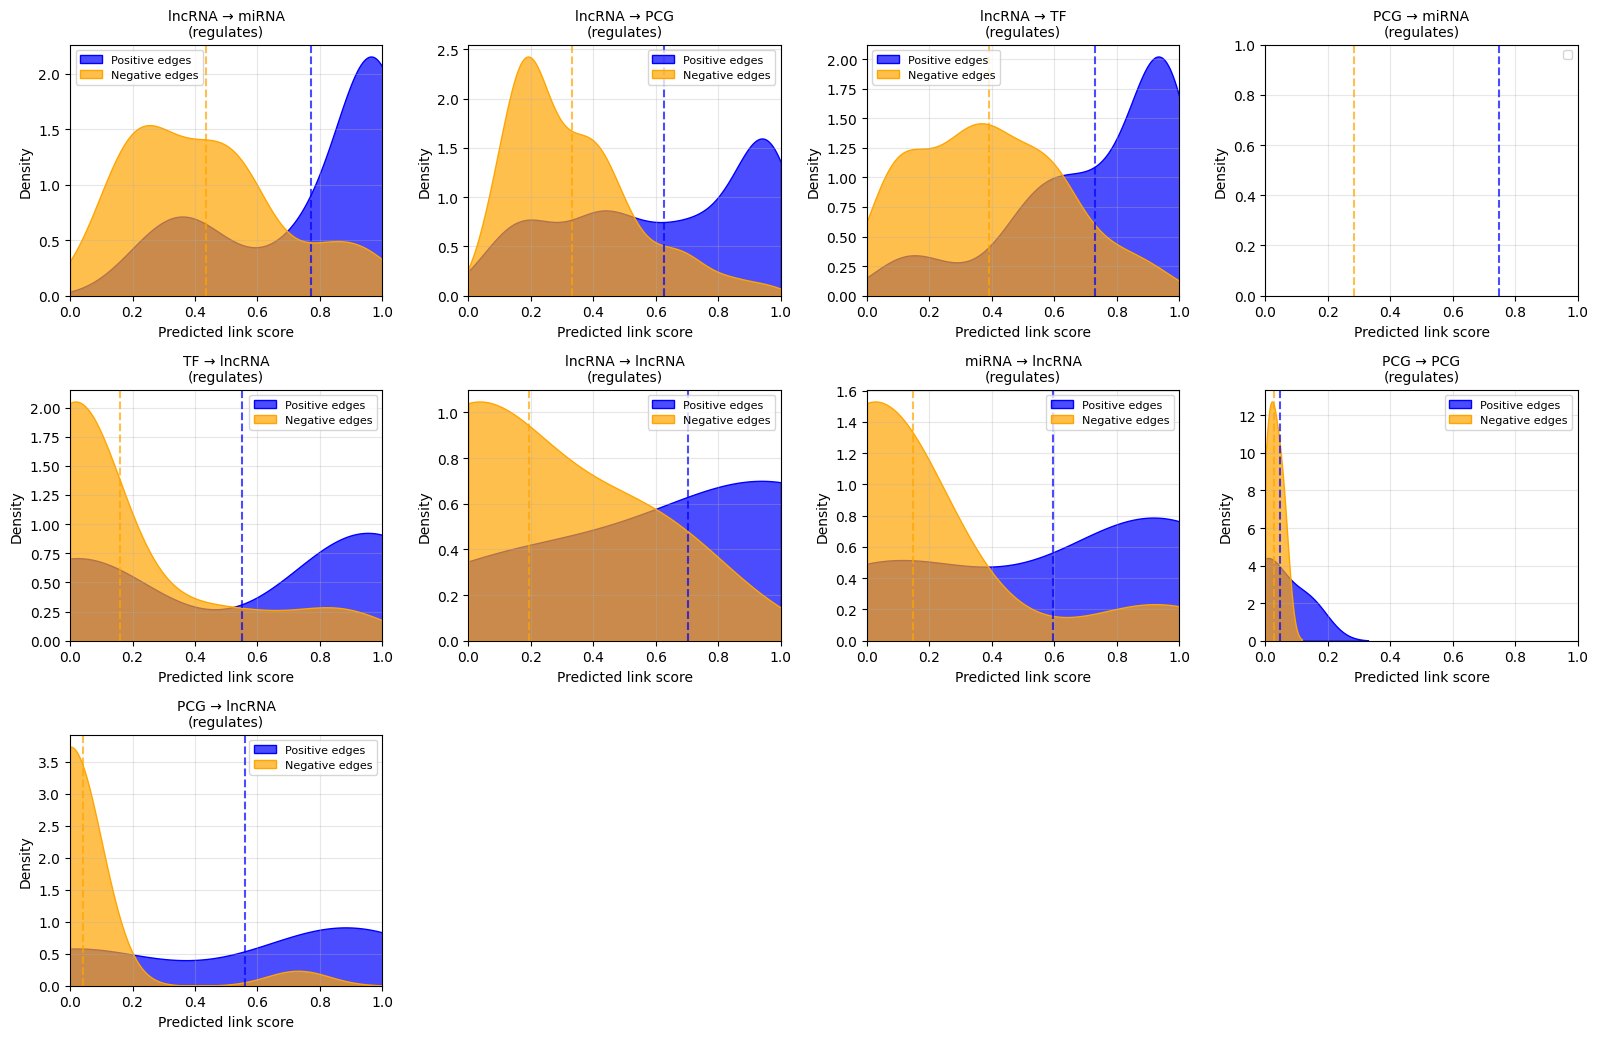

In [16]:
def plot_edge_score_distributions(
    model, predictor, data, edge_types, device, max_samples=1000
):
    """
    Plot score distributions for positive and negative edges across all edge types.
    """
    model.eval()
    predictor.eval()

    all_pos_scores = []
    all_neg_scores = []

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        for edge_type in edge_types:
            if not hasattr(data[edge_type], "edge_label_index"):
                continue

            edge_label_index = data[edge_type].edge_label_index
            edge_labels = data[edge_type].edge_label

            if edge_label_index.shape[1] == 0:
                continue

            pos_mask = edge_labels == 1
            neg_mask = edge_labels == 0

            pos_edge_index = edge_label_index[:, pos_mask]
            neg_edge_index = edge_label_index[:, neg_mask]

            if pos_edge_index.shape[1] > max_samples:
                indices = torch.randperm(pos_edge_index.shape[1])[:max_samples]
                pos_edge_index = pos_edge_index[:, indices]

            if neg_edge_index.shape[1] > max_samples:
                indices = torch.randperm(neg_edge_index.shape[1])[:max_samples]
                neg_edge_index = neg_edge_index[:, indices]

            if pos_edge_index.shape[1] > 0:
                src_emb_pos = out[edge_type[0]][pos_edge_index[0]]
                dst_emb_pos = out[edge_type[2]][pos_edge_index[1]]
                pos_edge_attrs = get_edge_attributes(
                    data, edge_type, pos_edge_index, device
                )

                pos_existence_logits, _ = predictor(
                    src_emb_pos, dst_emb_pos, pos_edge_attrs
                )
                pos_scores = torch.sigmoid(pos_existence_logits)
                all_pos_scores.extend(pos_scores.cpu().numpy())

            if neg_edge_index.shape[1] > 0:
                src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
                dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]
                neg_edge_attrs = get_edge_attributes(
                    data, edge_type, neg_edge_index, device
                )

                neg_existence_logits, _ = predictor(
                    src_emb_neg, dst_emb_neg, neg_edge_attrs
                )
                neg_scores = torch.sigmoid(neg_existence_logits)
                all_neg_scores.extend(neg_scores.cpu().numpy())

    plt.figure(figsize=(10, 6))

    if len(all_pos_scores) > 0 and len(all_neg_scores) > 0:
        all_pos_scores_clipped = np.clip(all_pos_scores, 0, 1)
        all_neg_scores_clipped = np.clip(all_neg_scores, 0, 1)

        sns.kdeplot(
            all_pos_scores_clipped,
            label="Positive edges",
            fill=True,
            alpha=0.7,
            clip=(0, 1),
        )
        sns.kdeplot(
            all_neg_scores_clipped,
            label="Negative edges",
            fill=True,
            alpha=0.7,
            clip=(0, 1),
        )

        plt.xlabel("Predicted link score")
        plt.ylabel("Density")
        plt.xlim(0, 1)
        plt.legend()
        plt.title(
            "Score distributions for positive and negative edges (All edge types)"
        )
        plt.grid(True, alpha=0.3)

        pos_mean = np.mean(all_pos_scores)
        neg_mean = np.mean(all_neg_scores)
        plt.axvline(
            pos_mean,
            color="blue",
            linestyle="--",
            alpha=0.7,
            label=f"Pos mean: {pos_mean:.3f}",
        )
        plt.axvline(
            neg_mean,
            color="orange",
            linestyle="--",
            alpha=0.7,
            label=f"Neg mean: {neg_mean:.3f}",
        )
        plt.legend()

        print(
            f"Positive edges - Mean: {pos_mean:.3f}, Std: {np.std(all_pos_scores):.3f}, Count: {len(all_pos_scores)}"
        )
        print(
            f"Negative edges - Mean: {neg_mean:.3f}, Std: {np.std(all_neg_scores):.3f}, Count: {len(all_neg_scores)}"
        )

        pos_min, pos_max = np.min(all_pos_scores), np.max(all_pos_scores)
        neg_min, neg_max = np.min(all_neg_scores), np.max(all_neg_scores)
        print(
            f"Score ranges - Positive: [{pos_min:.6f}, {pos_max:.6f}], Negative: [{neg_min:.6f}, {neg_max:.6f}]"
        )
    else:
        plt.text(
            0.5,
            0.5,
            "No data available for plotting",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
        )
        plt.title("Score distributions - No data available")

    plt.show()


def plot_edge_score_distributions_by_type(
    model, predictor, data, edge_types, device, max_samples=1000
):
    """
    Plot score distributions for positive and negative edges for each edge type separately.
    """
    model.eval()
    predictor.eval()

    edge_type_data = {}

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        for i, edge_type in enumerate(edge_types):
            edge_type_str = f"{edge_type[0]} → {edge_type[2]} ({edge_type[1]})"

            if not hasattr(data[edge_type], "edge_label_index"):
                continue

            edge_label_index = data[edge_type].edge_label_index
            edge_labels = data[edge_type].edge_label

            if edge_label_index.shape[1] == 0:
                continue

            pos_mask = edge_labels == 1
            neg_mask = edge_labels == 0

            pos_edge_index = edge_label_index[:, pos_mask]
            neg_edge_index = edge_label_index[:, neg_mask]

            if pos_edge_index.shape[1] > max_samples:
                indices = torch.randperm(pos_edge_index.shape[1])[:max_samples]
                pos_edge_index = pos_edge_index[:, indices]

            if neg_edge_index.shape[1] > max_samples:
                indices = torch.randperm(neg_edge_index.shape[1])[:max_samples]
                neg_edge_index = neg_edge_index[:, indices]

            pos_scores = []
            neg_scores = []

            if pos_edge_index.shape[1] > 0:
                src_emb_pos = out[edge_type[0]][pos_edge_index[0]]
                dst_emb_pos = out[edge_type[2]][pos_edge_index[1]]
                pos_edge_attrs = get_edge_attributes(
                    data, edge_type, pos_edge_index, device
                )

                pos_existence_logits, _ = predictor(
                    src_emb_pos, dst_emb_pos, pos_edge_attrs
                )
                pos_scores = torch.sigmoid(pos_existence_logits).cpu().numpy()

            if neg_edge_index.shape[1] > 0:
                src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
                dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]
                neg_edge_attrs = get_edge_attributes(
                    data, edge_type, neg_edge_index, device
                )

                neg_existence_logits, _ = predictor(
                    src_emb_neg, dst_emb_neg, neg_edge_attrs
                )
                neg_scores = torch.sigmoid(neg_existence_logits).cpu().numpy()

            if len(pos_scores) > 0 or len(neg_scores) > 0:
                edge_type_data[edge_type] = {
                    "pos_scores": pos_scores,
                    "neg_scores": neg_scores,
                }

    n_edge_types = len(edge_type_data)
    cols = min(4, n_edge_types)
    rows = (n_edge_types + cols - 1) // cols

    _, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
    if n_edge_types == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    else:
        axes = axes.flatten()

    for i, (edge_type, scores_data) in enumerate(edge_type_data.items()):
        ax = axes[i]
        pos_scores = scores_data["pos_scores"]
        neg_scores = scores_data["neg_scores"]

        if len(pos_scores) > 0:
            pos_scores = np.clip(pos_scores, 0, 1)
        if len(neg_scores) > 0:
            neg_scores = np.clip(neg_scores, 0, 1)

        if len(pos_scores) > 0:
            sns.kdeplot(
                pos_scores,
                label="Positive edges",
                fill=True,
                alpha=0.7,
                ax=ax,
                color="blue",
                clip=(0, 1),
            )
        if len(neg_scores) > 0:
            sns.kdeplot(
                neg_scores,
                label="Negative edges",
                fill=True,
                alpha=0.7,
                ax=ax,
                color="orange",
                clip=(0, 1),
            )

        ax.set_xlim(0, 1)

        if len(pos_scores) > 0:
            pos_mean = np.mean(pos_scores)
            ax.axvline(pos_mean, color="blue", linestyle="--", alpha=0.7)
        if len(neg_scores) > 0:
            neg_mean = np.mean(neg_scores)
            ax.axvline(neg_mean, color="orange", linestyle="--", alpha=0.7)

        edge_type_str = f"{edge_type[0]} → {edge_type[2]}"
        ax.set_title(f"{edge_type_str}\n({edge_type[1]})", fontsize=10)
        ax.set_xlabel("Predicted link score")
        ax.set_ylabel("Density")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    for i in range(n_edge_types, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


# Plot score distributions for training data
print("Plotting edge score distributions for training data:")
plot_edge_score_distributions(model, predictor, train_data, edge_types, device)

# Plot score distributions for test data
print("\nPlotting edge score distributions for test data:")
plot_edge_score_distributions(model, predictor, test_data, edge_types, device)

# Plot score distributions by edge type for test data
print("\n" + "=" * 60)
print("SCORE DISTRIBUTIONS BY EDGE TYPE (TEST DATA)")
print("=" * 60)
plot_edge_score_distributions_by_type(model, predictor, test_data, edge_types, device)